In [19]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *

np.random.seed(123)

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [20]:
# ode 
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = params
    
    # unpack variables
    od, pH = x 
    
    # growth rate modified by pH preference 
    # mu = mu_max * jnp.exp(-alpha * (pH - pref)**2)
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp(-Sigma_inv * (pH - pref)**2.) - delta)
    dpH = (gamma * od) * (pH * (2. - pH / 7.))
    
    return jnp.array([dod, dpH])  

# define transform function to constrain parameter values
def transform(params):
    
    # unpack parameters
    mu_max, pref, Sigma_inv, K_inv, delta, gamma = params
    
    # take exp of strictly positive parameters
    mu_max = jnp.exp2(mu_max)
    pref = jnp.exp2(pref)*7.
    Sigma_inv = jnp.exp2(Sigma_inv)/100.
    K_inv = jnp.exp2(K_inv)/10.
    delta = jnp.exp2(delta)/10.
    gamma = gamma/100.
    
    return jnp.array([mu_max, pref, Sigma_inv, K_inv, delta, gamma])

# define prior mean of transformed variables 
prior_mean = jnp.array([1., 7., 1., 1., 0., 0.])

# prior precision 
alpha = 10. # jnp.array([10, 1, 100, 1, 1])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [21]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [22]:
all_species = df.columns.values[3:]
all_species

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD'],
      dtype=object)

In [23]:
sp = all_species[11][:-3]
sp

'parc+'

In [13]:
df_species = pd.concat([df_exp[['Treatments', 'Time', 'pH', sp+'_OD']] 
                   for exp_name, df_exp in df.groupby("Treatments") if sp in exp_name])
df_species

,Treatments,Time,pH,parc+_OD
1134,parc+_pH4_0,0,5.018455,0.010000
1135,parc+_pH4_0,3,5.062536,0.010000
1136,parc+_pH4_0,6,5.037631,0.010000
1137,parc+_pH4_0,9,5.080743,0.010000
1138,parc+_pH4_0,24,5.020608,0.010000
...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.010000
1220,parc+_pH9_2,3,8.040755,0.183878
1221,parc+_pH9_2,6,7.873923,1.026189
1222,parc+_pH9_2,9,7.745788,2.903504


## Specify system state variables 

In [14]:
# names of species
species = [sp+'_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [15]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_species, 
            sys_vars = species, 
            prior_mean = prior_mean, 
            alpha=alpha, beta=10.)

## Fit the parameter posterior

In [16]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM(n_sample_sgd=1, 
                           n_sample_hypers=50, 
                           n_sample_evidence=100, 
                           patience=3)

print("Elapsed time {:.2f}s".format(time.time()-t0))

Computing model evidence...


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 211.80it/s]


Log evidence: -1886.496
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 192.99it/s]


Updating posterior...
Epoch 1, NEG ELBO: 114.125
Epoch 2, NEG ELBO: 88.590
Epoch 3, NEG ELBO: 81.317
Epoch 4, NEG ELBO: 77.210
Epoch 5, NEG ELBO: 74.640
Epoch 6, NEG ELBO: 73.374
Epoch 7, NEG ELBO: 71.998
Epoch 8, NEG ELBO: 67.435
Epoch 9, NEG ELBO: 68.608
Epoch 10, NEG ELBO: 68.361
set lr to 1.000e-02
Epoch 11, NEG ELBO: 73.750, Slope: -0.020
set lr to 1.000e-02
Epoch 12, NEG ELBO: 67.113, Slope: -0.015
Epoch 13, NEG ELBO: 70.022, Slope: -0.010
Epoch 14, NEG ELBO: 64.553, Slope: -0.010
Epoch 15, NEG ELBO: 65.883, Slope: -0.009
Epoch 16, NEG ELBO: 63.993, Slope: -0.009
Epoch 17, NEG ELBO: 64.312, Slope: -0.008
set lr to 1.000e-02
Epoch 18, NEG ELBO: 63.093, Slope: -0.011
Epoch 19, NEG ELBO: 67.000, Slope: -0.010
set lr to 1.000e-02
Epoch 20, NEG ELBO: 63.971, Slope: -0.010
Epoch 21, NEG ELBO: 67.383, Slope: -0.003
Epoch 22, NEG ELBO: 66.021, Slope: -0.002
decrease lr to 9.000e-03
Epoch 23, NEG ELBO: 63.180, Slope: 0.001
Epoch 24, NEG ELBO: 62.597, Slope: -0.002
decrease lr to 8.100e-03

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 199.91it/s]


Log evidence: -227.080
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 219.06it/s]


Updating posterior...
Epoch 1, NEG ELBO: 88.938
Epoch 2, NEG ELBO: 87.787
Epoch 3, NEG ELBO: 65.330
Epoch 4, NEG ELBO: 67.343
Epoch 5, NEG ELBO: 69.640
Epoch 6, NEG ELBO: 68.587
Epoch 7, NEG ELBO: 66.596
Epoch 8, NEG ELBO: 66.504
Epoch 9, NEG ELBO: 60.267
Epoch 10, NEG ELBO: 57.099
set lr to 1.000e-02
Epoch 11, NEG ELBO: 55.091, Slope: -0.028
Epoch 12, NEG ELBO: 72.713, Slope: -0.009
set lr to 1.000e-02
Epoch 13, NEG ELBO: 62.819, Slope: -0.010
Epoch 14, NEG ELBO: 66.224, Slope: -0.006
Epoch 15, NEG ELBO: 66.740, Slope: -0.000
decrease lr to 9.000e-03
Epoch 16, NEG ELBO: 64.017, Slope: 0.004
decrease lr to 8.100e-03
Epoch 17, NEG ELBO: 63.954, Slope: 0.006
decrease lr to 7.290e-03
Epoch 18, NEG ELBO: 70.730, Slope: 0.014
decrease lr to 6.561e-03
Epoch 19, NEG ELBO: 63.790, Slope: 0.011
decrease lr to 5.905e-03
Epoch 20, NEG ELBO: 64.179, Slope: 0.004
Epoch 21, NEG ELBO: 62.058, Slope: -0.007
Epoch 22, NEG ELBO: 63.393, Slope: -0.003
Epoch 23, NEG ELBO: 62.054, Slope: -0.007
Epoch 24, N

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 215.64it/s]


Log evidence: -210.074
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 220.72it/s]


Updating posterior...
Epoch 1, NEG ELBO: 120.974
Epoch 2, NEG ELBO: 79.454
Epoch 3, NEG ELBO: 80.383
Epoch 4, NEG ELBO: 87.992
Epoch 5, NEG ELBO: 80.600
Epoch 6, NEG ELBO: 77.385
Epoch 7, NEG ELBO: 78.328
Epoch 8, NEG ELBO: 80.959
Epoch 9, NEG ELBO: 78.174
Epoch 10, NEG ELBO: 81.409
Epoch 11, NEG ELBO: 79.653, Slope: -0.003
decrease lr to 9.000e-03
Epoch 12, NEG ELBO: 143.079, Slope: 0.022
decrease lr to 8.100e-03
Epoch 13, NEG ELBO: 260.455, Slope: 0.047
decrease lr to 7.290e-03
Epoch 14, NEG ELBO: 313.420, Slope: 0.072
decrease lr to 6.561e-03
Epoch 15, NEG ELBO: 274.390, Slope: 0.087
decrease lr to 5.905e-03
Epoch 16, NEG ELBO: 166.376, Slope: 0.076
decrease lr to 5.314e-03
Epoch 17, NEG ELBO: 286.999, Slope: 0.082
decrease lr to 4.783e-03
Epoch 18, NEG ELBO: 154.542, Slope: 0.058
decrease lr to 4.305e-03
Epoch 19, NEG ELBO: 226.217, Slope: 0.043
decrease lr to 3.874e-03
Epoch 20, NEG ELBO: 193.392, Slope: 0.017
set lr to 4.262e-03
Epoch 21, NEG ELBO: 188.713, Slope: -0.014
set lr t

/Users/Cissy/Desktop/Grad_School/Lab Work/Lab Note and Protocols/arc operon project/Liu_et_al_2024/model/diag_Gaussian.py:514: RuntimeWarning: overflow encountered in square
  v = beta2 * v + (1 - beta2) * (gradient ** 2)


set lr to 2.541e-03
Epoch 74, NEG ELBO: 167.364, Slope: -0.011
decrease lr to 2.287e-03
Epoch 75, NEG ELBO: 118.106, Slope: 0.000
Epoch 76, NEG ELBO: 155.081, Slope: -0.009
set lr to 2.516e-03
Epoch 77, NEG ELBO: 147.719, Slope: -0.016
set lr to 2.767e-03
Epoch 78, NEG ELBO: 103.005, Slope: -0.026
set lr to 3.044e-03
Epoch 79, NEG ELBO: 128.706, Slope: -0.036
set lr to 3.348e-03
Epoch 80, NEG ELBO: 109.957, Slope: -0.041
set lr to 3.683e-03
Epoch 81, NEG ELBO: 112.512, Slope: -0.046
set lr to 4.051e-03
Epoch 82, NEG ELBO: 101.283, Slope: -0.042
set lr to 4.457e-03
Epoch 83, NEG ELBO: 100.348, Slope: -0.037
set lr to 4.902e-03
Epoch 84, NEG ELBO: 110.444, Slope: -0.026
set lr to 5.392e-03
Epoch 85, NEG ELBO: 112.495, Slope: -0.029
set lr to 5.932e-03
Epoch 86, NEG ELBO: 112.086, Slope: -0.016
set lr to 6.525e-03
Epoch 87, NEG ELBO: 89.178, Slope: -0.011
decrease lr to 5.872e-03
Epoch 88, NEG ELBO: 157.557, Slope: 0.006
decrease lr to 5.285e-03
Epoch 89, NEG ELBO: 153.120, Slope: 0.026
d

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 93.85it/s]


Log evidence: -193.544
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 220.18it/s]


Updating posterior...
Epoch 1, NEG ELBO: 120.547
Epoch 2, NEG ELBO: 88.835
Epoch 3, NEG ELBO: 87.025
Epoch 4, NEG ELBO: 92.892
Epoch 5, NEG ELBO: 87.973
Epoch 6, NEG ELBO: 84.464
Epoch 7, NEG ELBO: 89.932
Epoch 8, NEG ELBO: 136.855
Epoch 9, NEG ELBO: 132.279
Epoch 10, NEG ELBO: 118.720
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 133.442, Slope: 0.043
decrease lr to 8.100e-03
Epoch 12, NEG ELBO: 131.550, Slope: 0.046
decrease lr to 7.290e-03
Epoch 13, NEG ELBO: 126.803, Slope: 0.041
decrease lr to 6.561e-03
Epoch 14, NEG ELBO: 131.562, Slope: 0.039
decrease lr to 5.905e-03
Epoch 15, NEG ELBO: 120.189, Slope: 0.025
decrease lr to 5.314e-03
Epoch 16, NEG ELBO: 126.178, Slope: 0.010
set lr to 5.846e-03
Epoch 17, NEG ELBO: 114.758, Slope: -0.011
set lr to 6.430e-03
Epoch 18, NEG ELBO: 113.889, Slope: -0.012
Epoch 19, NEG ELBO: 129.495, Slope: -0.006
set lr to 7.073e-03
Epoch 20, NEG ELBO: 119.179, Slope: -0.011
Epoch 21, NEG ELBO: 128.989, Slope: -0.005
Epoch 22, NEG ELBO: 116.285, Slope: 

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 194.82it/s]


Log evidence: -201.229
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 231.77it/s]


Updating posterior...
Epoch 1, NEG ELBO: 91.101
Epoch 2, NEG ELBO: 71.529
Epoch 3, NEG ELBO: 69.642
Epoch 4, NEG ELBO: 73.851
Epoch 5, NEG ELBO: 69.834
Epoch 6, NEG ELBO: 69.871
Epoch 7, NEG ELBO: 69.800
Epoch 8, NEG ELBO: 68.649
Epoch 9, NEG ELBO: 69.927
Epoch 10, NEG ELBO: 72.675
Epoch 11, NEG ELBO: 70.289, Slope: -0.001
decrease lr to 9.000e-03
Epoch 12, NEG ELBO: 99.289, Slope: 0.016
decrease lr to 8.100e-03
Epoch 13, NEG ELBO: 73.021, Slope: 0.013
decrease lr to 7.290e-03
Epoch 14, NEG ELBO: 93.783, Slope: 0.024
decrease lr to 6.561e-03
Epoch 15, NEG ELBO: 98.312, Slope: 0.032
decrease lr to 5.905e-03
Epoch 16, NEG ELBO: 76.718, Slope: 0.026
decrease lr to 5.314e-03
Epoch 17, NEG ELBO: 107.391, Slope: 0.032
decrease lr to 4.783e-03
Epoch 18, NEG ELBO: 73.933, Slope: 0.019
decrease lr to 4.305e-03
Epoch 19, NEG ELBO: 94.525, Slope: 0.016
decrease lr to 3.874e-03
Epoch 20, NEG ELBO: 94.972, Slope: 0.012
Epoch 21, NEG ELBO: 81.613, Slope: -0.002
decrease lr to 3.487e-03
Epoch 22, NEG

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.89it/s]


Log evidence: -189.206
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 237.04it/s]


Updating posterior...
Epoch 1, NEG ELBO: 99.738
Epoch 2, NEG ELBO: 93.983
Epoch 3, NEG ELBO: 94.468
Epoch 4, NEG ELBO: 94.055
Epoch 5, NEG ELBO: 96.487
Epoch 6, NEG ELBO: 99.885
Epoch 7, NEG ELBO: 95.112
Epoch 8, NEG ELBO: 95.526
Epoch 9, NEG ELBO: 94.408
Epoch 10, NEG ELBO: 96.110
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 95.588, Slope: 0.001
decrease lr to 8.100e-03
Epoch 12, NEG ELBO: 100.791, Slope: 0.003
decrease lr to 7.290e-03
Epoch 13, NEG ELBO: 93.275, Slope: 0.000
Epoch 14, NEG ELBO: 84.811, Slope: -0.007
Epoch 15, NEG ELBO: 94.153, Slope: -0.007
Epoch 16, NEG ELBO: 97.346, Slope: -0.002
Epoch 17, NEG ELBO: 96.471, Slope: -0.001
decrease lr to 6.561e-03
Epoch 18, NEG ELBO: 98.079, Slope: 0.001
decrease lr to 5.905e-03
Epoch 19, NEG ELBO: 101.677, Slope: 0.004
decrease lr to 5.314e-03
Epoch 20, NEG ELBO: 94.056, Slope: 0.003
decrease lr to 4.783e-03
Epoch 21, NEG ELBO: 98.077, Slope: 0.005
decrease lr to 4.305e-03
Epoch 22, NEG ELBO: 95.000, Slope: 0.007
decrease lr to 3.87

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.91it/s]


Log evidence: -191.251
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 227.08it/s]


Updating posterior...
Epoch 1, NEG ELBO: 100.232
Epoch 2, NEG ELBO: 95.290
Epoch 3, NEG ELBO: 125.062
Epoch 4, NEG ELBO: 97.919
Epoch 5, NEG ELBO: 94.733
Epoch 6, NEG ELBO: 95.639
Epoch 7, NEG ELBO: 95.974
Epoch 8, NEG ELBO: 82.768
Epoch 9, NEG ELBO: 95.947
Epoch 10, NEG ELBO: 100.030
Epoch 11, NEG ELBO: 102.056, Slope: -0.008
Epoch 12, NEG ELBO: 99.630, Slope: -0.009
decrease lr to 9.000e-03
Epoch 13, NEG ELBO: 93.677, Slope: 0.003
decrease lr to 8.100e-03
Epoch 14, NEG ELBO: 98.615, Slope: 0.006
decrease lr to 7.290e-03
Epoch 15, NEG ELBO: 97.757, Slope: 0.006
decrease lr to 6.561e-03
Epoch 16, NEG ELBO: 94.281, Slope: 0.005
decrease lr to 5.905e-03
Epoch 17, NEG ELBO: 98.609, Slope: 0.006
Epoch 18, NEG ELBO: 94.430, Slope: -0.004
Epoch 19, NEG ELBO: 94.758, Slope: -0.006
Epoch 20, NEG ELBO: 94.939, Slope: -0.006
Epoch 21, NEG ELBO: 96.454, Slope: -0.003
Epoch 22, NEG ELBO: 91.973, Slope: -0.003
Epoch 23, NEG ELBO: 94.815, Slope: -0.005
Epoch 24, NEG ELBO: 94.841, Slope: -0.003
Epoch

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 66.99it/s]


Log evidence: -167.365
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 225.58it/s]


Updating posterior...
Epoch 1, NEG ELBO: 106.193
Epoch 2, NEG ELBO: 102.105
Epoch 3, NEG ELBO: 105.812
Epoch 4, NEG ELBO: 104.897
Epoch 5, NEG ELBO: 90.727
Epoch 6, NEG ELBO: 103.490
Epoch 7, NEG ELBO: 94.973
Epoch 8, NEG ELBO: 99.073
Epoch 9, NEG ELBO: 135.918
Epoch 10, NEG ELBO: 104.498
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 97.391, Slope: 0.005
decrease lr to 8.100e-03
Epoch 12, NEG ELBO: 120.585, Slope: 0.011
decrease lr to 7.290e-03
Epoch 13, NEG ELBO: 105.904, Slope: 0.011
decrease lr to 6.561e-03
Epoch 14, NEG ELBO: 106.033, Slope: 0.011
decrease lr to 5.905e-03
Epoch 15, NEG ELBO: 103.923, Slope: 0.003
Epoch 16, NEG ELBO: 97.992, Slope: -0.003
Epoch 17, NEG ELBO: 104.842, Slope: -0.009
Epoch 18, NEG ELBO: 116.757, Slope: -0.010
Epoch 19, NEG ELBO: 100.632, Slope: -0.000
Epoch 20, NEG ELBO: 90.735, Slope: -0.008
set lr to 6.495e-03
Epoch 21, NEG ELBO: 92.544, Slope: -0.017
Epoch 22, NEG ELBO: 104.021, Slope: -0.008
Epoch 23, NEG ELBO: 100.058, Slope: -0.007
Epoch 24, NEG E

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 146.54it/s]


Log evidence: -209.552
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 222.82it/s]


Updating posterior...
Epoch 1, NEG ELBO: 88.289
Epoch 2, NEG ELBO: 73.477
Epoch 3, NEG ELBO: 71.817
Epoch 4, NEG ELBO: 69.324
Epoch 5, NEG ELBO: 72.364
Epoch 6, NEG ELBO: 72.529
Epoch 7, NEG ELBO: 70.210
Epoch 8, NEG ELBO: 68.425
Epoch 9, NEG ELBO: 106.743
Epoch 10, NEG ELBO: 115.077
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 111.960, Slope: 0.043
decrease lr to 8.100e-03
Epoch 12, NEG ELBO: 108.942, Slope: 0.050
decrease lr to 7.290e-03
Epoch 13, NEG ELBO: 112.053, Slope: 0.053
decrease lr to 6.561e-03
Epoch 14, NEG ELBO: 104.945, Slope: 0.048
decrease lr to 5.905e-03
Epoch 15, NEG ELBO: 105.431, Slope: 0.040
decrease lr to 5.314e-03
Epoch 16, NEG ELBO: 105.875, Slope: 0.029
decrease lr to 4.783e-03
Epoch 17, NEG ELBO: 101.858, Slope: 0.012
Epoch 18, NEG ELBO: 118.055, Slope: -0.002
decrease lr to 4.305e-03
Epoch 19, NEG ELBO: 117.707, Slope: 0.001
decrease lr to 3.874e-03
Epoch 20, NEG ELBO: 117.896, Slope: 0.007
decrease lr to 3.487e-03
Epoch 21, NEG ELBO: 126.154, Slope: 0.014
de

100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  8.25it/s]


Log evidence: -189.463
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 239.86it/s]


Updating posterior...
Epoch 1, NEG ELBO: 98.376
Epoch 2, NEG ELBO: 68.719
Epoch 3, NEG ELBO: 78.191
Epoch 4, NEG ELBO: 75.982
Epoch 5, NEG ELBO: 96.126
Epoch 6, NEG ELBO: 74.194
Epoch 7, NEG ELBO: 91.986
Epoch 8, NEG ELBO: 75.487
Epoch 9, NEG ELBO: 85.669
Epoch 10, NEG ELBO: 73.714
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 76.733, Slope: 0.003
decrease lr to 8.100e-03
Epoch 12, NEG ELBO: 92.345, Slope: 0.002
decrease lr to 7.290e-03
Epoch 13, NEG ELBO: 84.684, Slope: 0.001
Epoch 14, NEG ELBO: 73.082, Slope: -0.009
Epoch 15, NEG ELBO: 77.983, Slope: -0.002
Epoch 16, NEG ELBO: 75.684, Slope: -0.009
decrease lr to 6.561e-03
Epoch 17, NEG ELBO: 85.100, Slope: 0.001
Epoch 18, NEG ELBO: 70.469, Slope: -0.008
Epoch 19, NEG ELBO: 78.099, Slope: -0.004
set lr to 7.217e-03
Epoch 20, NEG ELBO: 71.891, Slope: -0.012
set lr to 7.939e-03
Epoch 21, NEG ELBO: 73.501, Slope: -0.016
set lr to 8.733e-03
Epoch 22, NEG ELBO: 71.337, Slope: -0.011
Epoch 23, NEG ELBO: 78.049, Slope: -0.003
Epoch 24, NEG E

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 225.33it/s]

Log evidence: -183.170
Elapsed time 39.65s


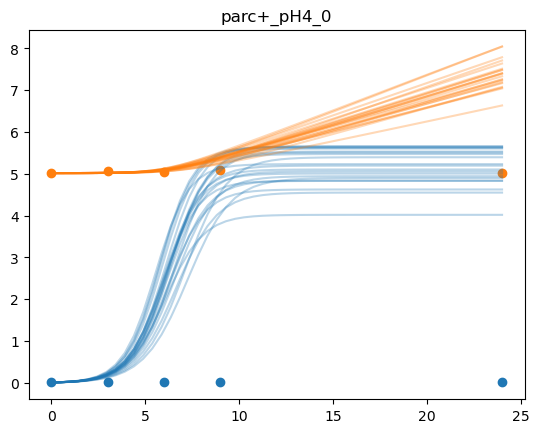

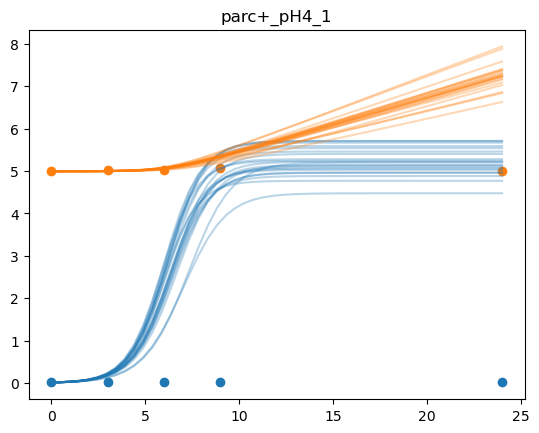

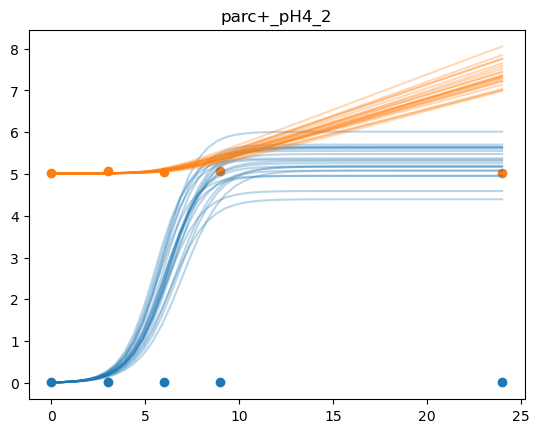

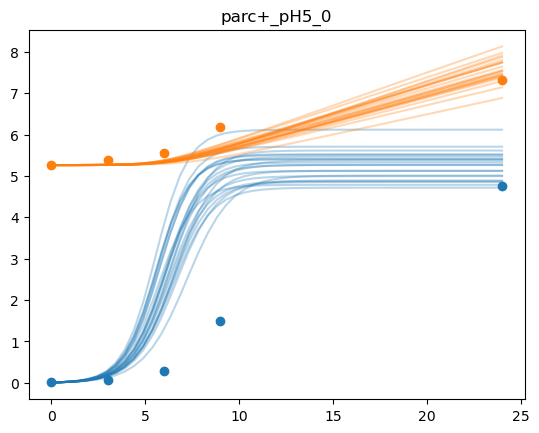

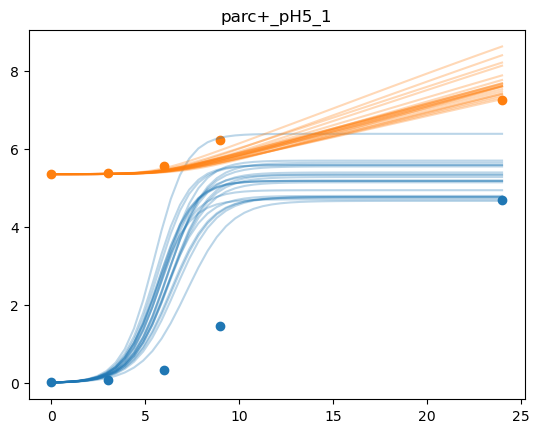

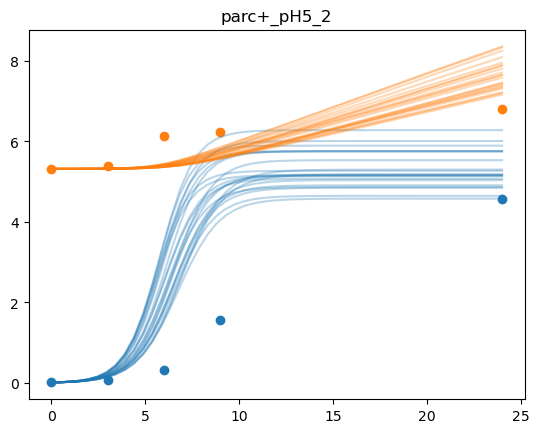

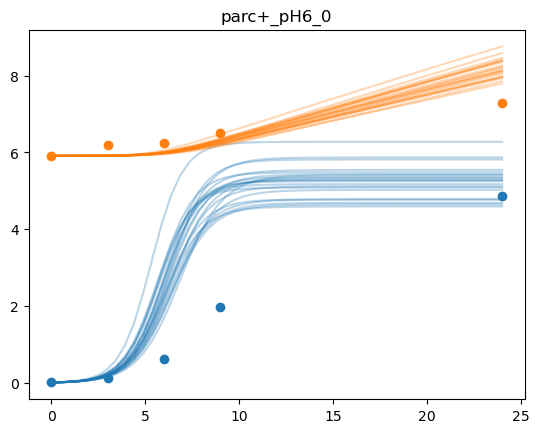

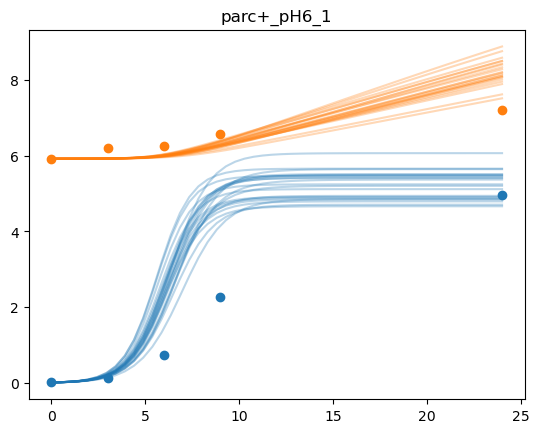

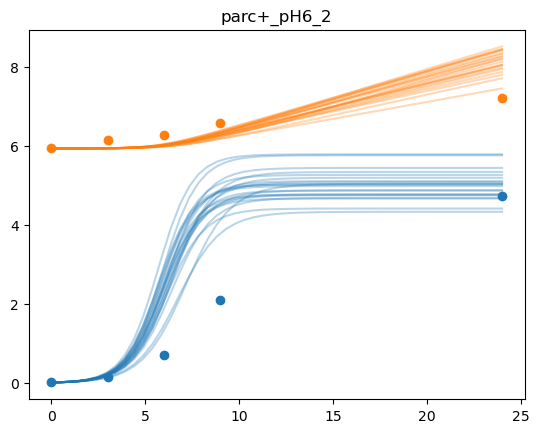

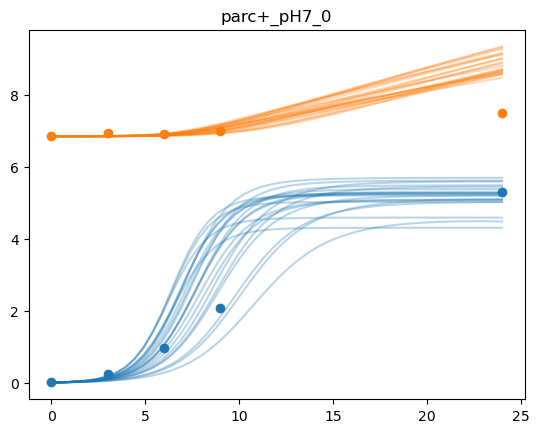

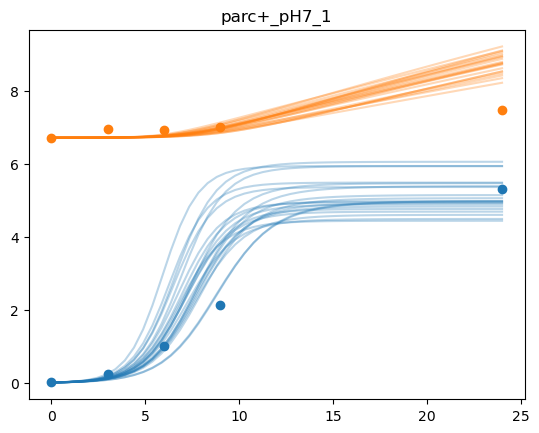

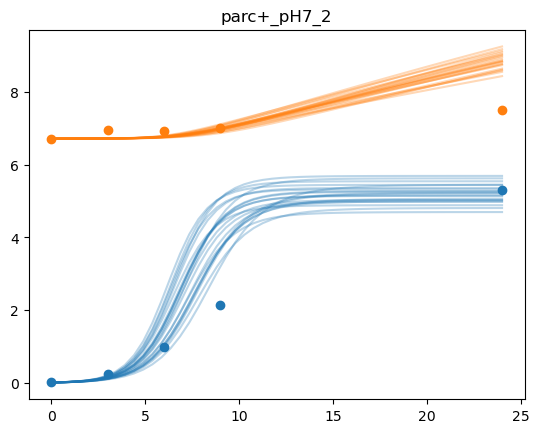

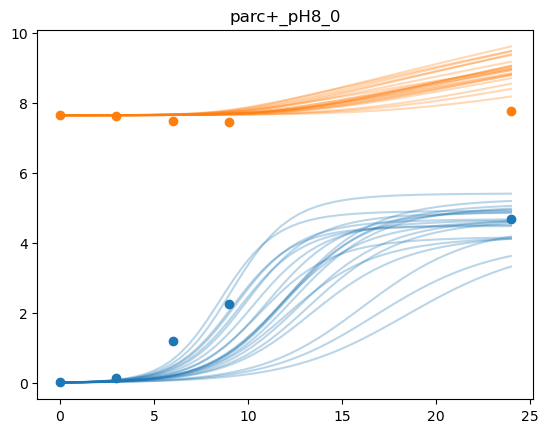

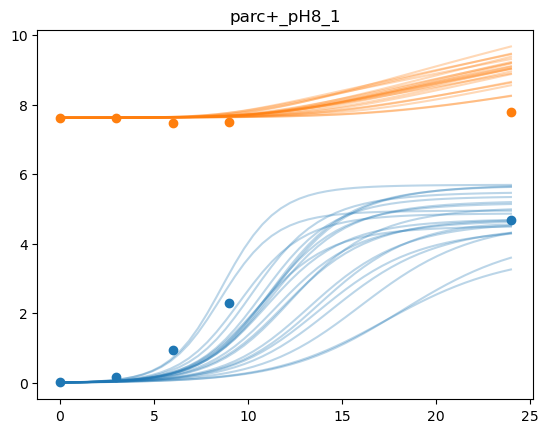

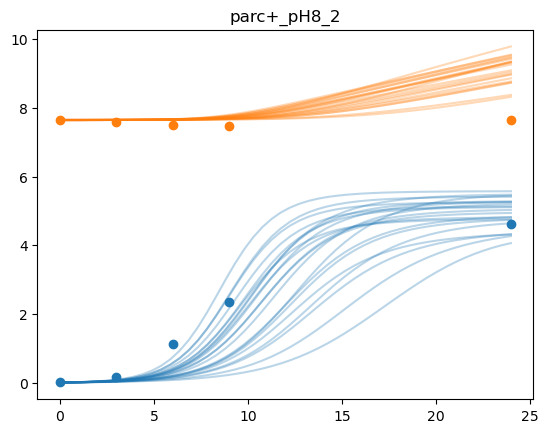

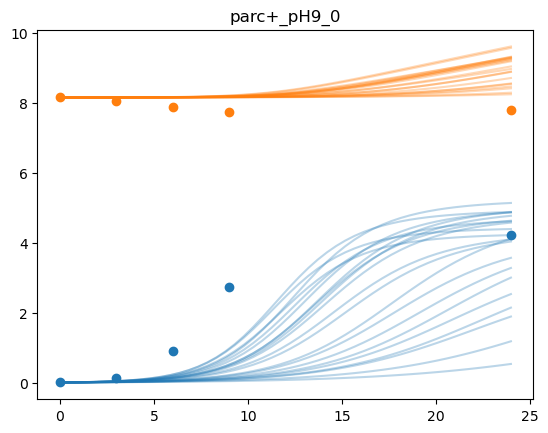

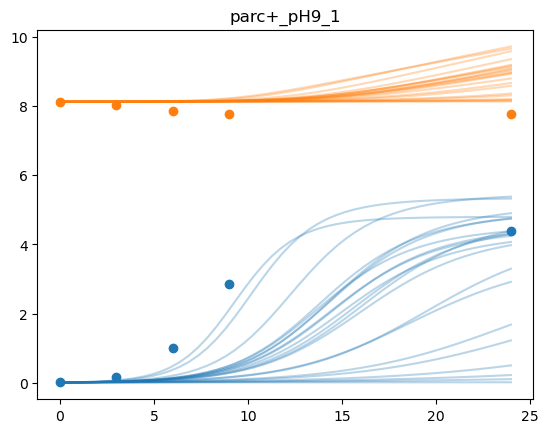

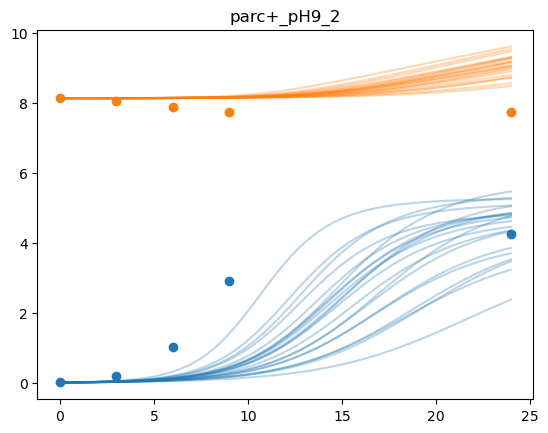

In [17]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_species.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    y_preds = ode_model.predict_sample(x0, t_eval)
    
    # plot 
    for i, s in enumerate(species[:2]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

## Save parameter values

In [18]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params.to_csv('Fitting/'+sp+'_param.csv')